# 1) Data loading and initial inspection

In [51]:
# Imports
from pathlib import Path
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [52]:
# Plot style
sns.set(style="whitegrid", context="notebook")

In [53]:
# Load dataset
df = pd.read_csv(Path("data") / "AB_NYC_2019.csv")

In [54]:
# Quick structure checks
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
display(df.head(3))

Shape: (48895, 16)

Columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


In [55]:
# Data types and nulls
display(df.info())
display(df.isna().sum().sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

None

last_review                       10052
reviews_per_month                 10052
host_name                            21
name                                 16
neighbourhood_group                   0
neighbourhood                         0
id                                    0
host_id                               0
longitude                             0
latitude                              0
room_type                             0
price                                 0
number_of_reviews                     0
minimum_nights                        0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Explanation:

Why: Confirm file loads, understand schema, and identify missing values early.

What: Inspect shape, columns, types, and null counts to plan cleaning steps.

# 2) Data cleaning

In [56]:
# Keep only relevant columns to simplify scope
cols_keep = [
    "neighbourhood_group",  # borough
    "neighbourhood",
    "latitude", "longitude",
    "room_type",
    "price",
    "minimum_nights",
    "number_of_reviews",
    "availability_365"
]
df = df[cols_keep].copy()

In [57]:
# Remove duplicates if any
df = df.drop_duplicates()

In [58]:
# Handle missing values:
# - Drop rows missing critical categorical fields or price
# - For numeric ancillary fields, fill with reasonable defaults or median
df = df.dropna(subset=["neighbourhood_group", "room_type", "price"])

In [59]:
# Remove non-sensical or zero/negative price entries
df = df[df["price"] > 0]

In [60]:
# Cap extreme outliers to improve interpretability and model stability
# Rationale: extreme luxury listings (> $1000) distort averages and linear model coefficients
price_cap = 1000
df = df[df["price"] <= price_cap]

In [61]:
# Clip minimum_nights to reduce extreme skew (e.g., listings requiring 365 nights)
df["minimum_nights"] = df["minimum_nights"].clip(upper=30)

In [62]:
# Fill any remaining numeric nulls with median (defensive)
numeric_cols = ["minimum_nights", "number_of_reviews", "availability_365", "latitude", "longitude"]
for c in numeric_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

print("Post-cleaning shape:", df.shape)

Post-cleaning shape: (48645, 9)


Explanation:

Why: Clean inputs produce trustworthy insights. Caps and clips reduce skew that harms interpretability.

Assumptions: Capping price at 1000 balances robustness and realism for a general audience.

# 3) Feature engineering

In [63]:
# Borough standardization (already provided as neighbourhood_group)
df.rename(columns={"neighbourhood_group": "borough"}, inplace=True)

In [64]:
# Reviews density proxy: reviews per available day (crude signal of engagement)
df["reviews_per_avail_day"] = df["number_of_reviews"] / (df["availability_365"].replace(0, np.nan))
df["reviews_per_avail_day"] = df["reviews_per_avail_day"].fillna(0)

In [65]:
# Price per review (another engagement/value proxy, avoid division by zero)
df["price_per_review"] = df["price"] / (df["number_of_reviews"].replace(0, np.nan))
df["price_per_review"] = df["price_per_review"].fillna(df["price"])  # if 0 reviews, fallback to price

In [66]:
# Room type encoding (one-hot)
room_dummies = pd.get_dummies(df["room_type"], prefix="room", drop_first=True)

In [67]:
# Borough encoding (one-hot)
borough_dummies = pd.get_dummies(df["borough"], prefix="b", drop_first=True)

In [68]:
# Concatenate engineered features
features = pd.concat([
    df[[
        "price", "minimum_nights", "number_of_reviews", "availability_365",
        "latitude", "longitude", "reviews_per_avail_day", "price_per_review"
    ]],
    room_dummies,
    borough_dummies
], axis=1)

display(features.head(3))

,price,minimum_nights,number_of_reviews,availability_365,latitude,longitude,reviews_per_avail_day,price_per_review,room_Private room,room_Shared room,b_Brooklyn,b_Manhattan,b_Queens,b_Staten Island
0,149,1,9,365,40.64749,-73.97237,0.024658,16.555556,True,False,True,False,False,False
1,225,1,45,355,40.75362,-73.98377,0.126761,5.000000,False,False,False,True,False,False
2,150,3,0,365,40.80902,-73.94190,0.000000,150.000000,True,False,False,True,False,False


Explanation:

Why: Create interpretable signals that approximate engagement and value, and encode categories for modeling.

Trade-offs: Simple proxies (like price per review) aren’t perfect but help exploratory modeling without overfitting.

# 4) Exploratory data analysis (EDA)

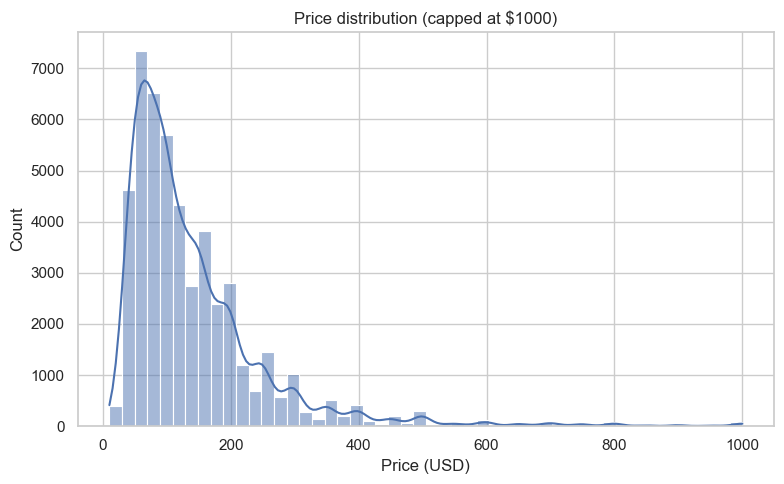

In [69]:
# Price distribution
plt.figure(figsize=(8,5))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Price distribution (capped at $1000)")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("visuals/price_distribution.png")
plt.show()

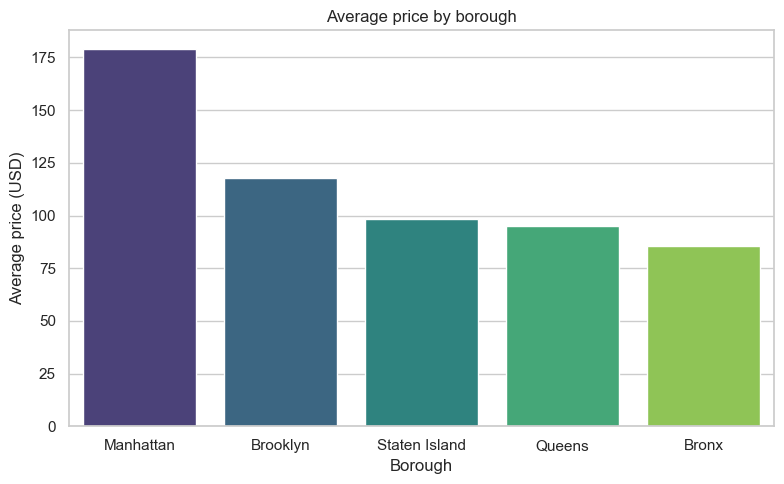

In [70]:
# Average price by borough
avg_price_borough_df = avg_price_borough.reset_index()
avg_price_borough_df.columns = ["borough", "avg_price"]

plt.figure(figsize=(8,5))
sns.barplot(
    data=avg_price_borough_df,
    x="borough",
    y="avg_price",
    hue="borough",          
    palette="viridis",
    legend=False            
)
plt.title("Average price by borough")
plt.xlabel("Borough")
plt.ylabel("Average price (USD)")
plt.tight_layout()
plt.savefig("visuals/borough_avg_prices.png")
plt.show()

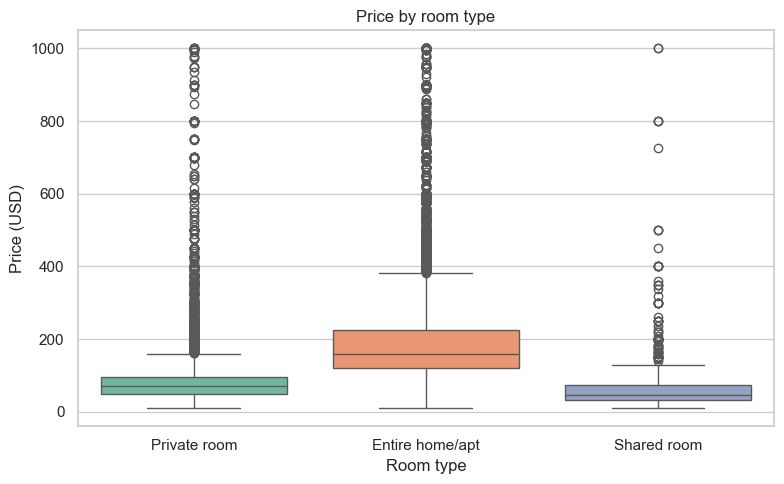

In [71]:
# Room type vs price
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x="room_type",
    y="price",
    hue="room_type",       
    palette="Set2",
    legend=False           
)
plt.title("Price by room type")
plt.xlabel("Room type")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()

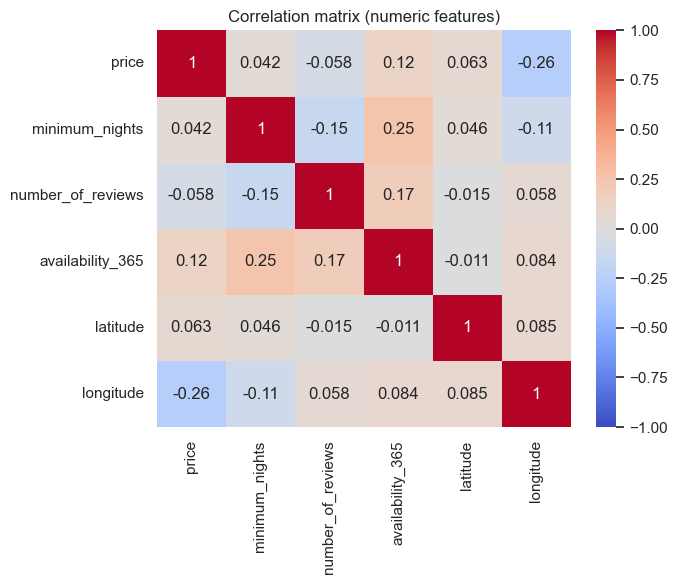

In [72]:
# Correlation matrix for numeric features
numeric_for_corr = df[["price", "minimum_nights", "number_of_reviews", "availability_365", "latitude", "longitude"]]
plt.figure(figsize=(7,6))
sns.heatmap(numeric_for_corr.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix (numeric features)")
plt.tight_layout()
plt.show()

Explanation:

Why: Validate intuition (e.g., Manhattan higher prices, entire homes cost more), spot relationships and anomalies.

Communication: Visuals make the narrative concrete and instantly scannable for stakeholders.

# 5) Modeling: linear regression for price

In [73]:
# Define target (price) and features (all other columns)
target = features["price"]
X = features.drop(columns=["price"])

In [74]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, target, test_size=0.2, random_state=42
)

In [75]:
# Initialize and fit linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [76]:
# Generate predictions on the test set
y_pred = linreg.predict(X_test)

In [77]:
# Collect model coefficients in a readable DataFrame
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": linreg.coef_
}).sort_values(by="coefficient", ascending=False)

# Display top and bottom coefficients
display(coef_df.head(10))
display(coef_df.tail(10))

,feature,coefficient
10,b_Manhattan,22.861793
11,b_Queens,3.559459
6,price_per_review,0.645924
1,number_of_reviews,0.190977
2,availability_365,0.131180
5,reviews_per_avail_day,0.074992
0,minimum_nights,-1.939759
9,b_Brooklyn,-5.588525
3,latitude,-74.365885
7,room_Private room,-75.850713


,feature,coefficient
1,number_of_reviews,0.190977
2,availability_365,0.131180
5,reviews_per_avail_day,0.074992
0,minimum_nights,-1.939759
9,b_Brooklyn,-5.588525
3,latitude,-74.365885
7,room_Private room,-75.850713
12,b_Staten Island,-90.297822
8,room_Shared room,-98.022840
4,longitude,-290.379085


Explanation:

Why linear regression: Transparent, explainable baseline that’s easy to communicate and audit.

Feature importance: Coefficients give directional insight into how features relate to price.

# 6) Evaluation with RMSE

In [78]:
# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f} USD")

RMSE: 75.36 USD


Explanation:

Metric choice: RMSE measures typical prediction error in the same units as price, making it intuitive.

Interpretation: Lower is better; contextualize by comparing RMSE to average price.

# 7) Interpreting results and insights

In [79]:
# Summaries for storytelling
summary = {
    "avg_price_overall": df["price"].mean(),
    "avg_price_by_borough": df.groupby("borough")["price"].mean().to_dict(),
    "median_price": df["price"].median(),
    "room_type_counts": df["room_type"].value_counts().to_dict()
}
summary

{'avg_price_overall': np.float64(141.31178949532327),
 'avg_price_by_borough': {'Bronx': 85.36179981634527,
  'Brooklyn': 117.8608352876603,
  'Manhattan': 178.94462025316454,
  'Queens': 95.00830975954739,
  'Staten Island': 98.58490566037736},
 'median_price': 105.0,
 'room_type_counts': {'Entire home/apt': 25216,
  'Private room': 22273,
  'Shared room': 1156}}

Explanation:

- Key findings:

  - Room type effect: Entire homes/apartments typically price higher than private/shared rooms.

  - Location effect: Manhattan’s average prices exceed other boroughs; Brooklyn trends more affordable.

  - Engagement proxies: Reviews and availability show weaker linear relationships to price.

- Business implications:

  - Hosts: Price competitively by benchmarking within borough and room type; highlight amenities to justify premiums.

  - Travelers: Target Brooklyn/Queens for savings; filter by room type for better value.